<a href="https://colab.research.google.com/github/jacquesbilombe/CRM-RFM-Analysis/blob/main/CustomerClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset for this project can be found on the project's GitHub repository or at [Kaggle](https://www.kaggle.com/datasets/ddosad/auto-sales-data). This project serves as a case study for the Data Science and Analytics course at PUC RIO. For more information, please refer to the project README.

In [30]:
import os
import csv
import sys
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import stats
from pathlib import Path
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Other configurations

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"

# Download the zip file
!wget -q $url

# Unzip the file
!unzip -q online+retail+ii.zip

## Exploratory Data Analysis

In [19]:
# Read the excel file
DF = pd.read_excel("online_retail_II.xlsx")


In [20]:
df = DF.copy()
# Display the dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
def summary_data(df, head=5):
    func = {
        "Head": df.head(head),
        "Info": df.info(),
        "Shape": df.shape,
        "Ndim": df.ndim,
        "Null": df.isnull().sum(),
        "Describe": df.describe().T
    }

    for n, f in func.items():
        print("\n################### ", n, " ###################\n")
        if isinstance(f, pd.DataFrame) or isinstance(f, pd.Series):
            print(f)
        else:
            print(f)

summary_data(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB

###################  Head  ###################

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY

- The summary function revealed null values in the dataset and negative values in the "Quantity" column, indicating potential refunds requested by customers. For the purposes of this analysis, these entries will be removed from the database.

- The dataset only has the quantity of items saled and their price, a column of Total Prie will be aggregate to the database

In [24]:
# Dropping Missing Values
df = df.dropna()

df = df[df['Quantity'] > 0]

# Total price column
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.tail(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom,3.90


## RFM Analysis
CRM Analytics employs various methods to gain insights into customer behavior, with RFM Analysis being one of the prominent techniques. RFM stands for Recency, Frequency, and Monetary, representing distinct aspects of customer engagement. Each of these components provides valuable insights into customer behavior and preferences.

- Recency is determined by computing the time elapsed since a customer's last interaction, typically a purchase, up to the date of analysis. This calculation entails subtracting the customer's last shopping date from the analysis date, yielding a duration. A shorter duration indicates a more recent shopping activity, implying a higher likelihood of brand retention and future purchases. Moreover, it serves as a means to identify customers who have refrained from shopping for an extended period, enabling targeted efforts to re-engage them with the store or brand. For this analysis, we'll consider today's date as the date of the last purchase plus one day to avoid "null" value. If this doesn't apply to your situation, please provide the date in string format `YYYY-MM-DD` in the following function.
- Frequency represents the frequency with which a customer makes purchases. By analyzing purchase patterns, businesses can discern recurring buying cycles among customers. Armed with this knowledge, proactive measures can be implemented to anticipate when customers are likely to return to the store or when they may have specific needs. Leveraging insights into purchasing frequencies enables businesses to strategically engage with customers through timely reminders or targeted marketing initiatives.
- The monetary value represents the total amount of money spent by a customer through their purchases, reflecting their overall expenditure. While this metric effectively identifies high-spending customers, it also poses the risk of overlooking those who spend smaller amounts or are new to the business. Consequently, solely focusing on monetary value may inadvertently alienate certain customer segments. Thus, businesses should adopt a balanced approach, considering other factors such as recency and frequency, to ensure inclusive and effective customer engagement strategies.

The script will use `pd.groupby` on the "CustomerID" to calculate the RFM and to aggregate transaction data for each customer. This enables algorithm to calculate RFM metrics individually for each customer, providing valuable insights into their purchasing behavior and overall engagement with the business.


In [37]:
def rfm_date(df, to_day):
  if to_day == "":
    return df["InvoiceDate"].max() + pd.Timedelta(days=1)
  else:
    # Check if the given date value if correct
    # before executing the code and deal with the error
    try:
      return datetime.strptime(to_day, "%Y-%m-%d")
    except ValueError as e:
      print("\n Wrong date value, please try againg with this format 'YYYY-MM-DD'")
      sys.exit(0)


rfm = df.groupby('Customer ID').agg({
                            'InvoiceDate': lambda InvoiceDate: (rfm_date(df=df, to_day="") - InvoiceDate.max()).days,  # Recency
                            'Invoice': lambda Invoice: Invoice.nunique(),  # Frequency
                            'TotalPrice': lambda TotalPrice: TotalPrice.sum()  # Monetary
                            })

# Rename the columns to recency, frequency, and monetary
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head(5)

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [27]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4314.0,91.269124,96.943482,1.0,18.00,53.00,136.0000,374.00
frequency,4314.0,4.454103,8.168658,1.0,1.00,2.00,5.0000,205.00
monetary,4314.0,2047.288659,8912.523243,0.0,307.95,705.55,1722.8025,349164.35


In [39]:
# Customers which monetery value igual to zero isn't what we want to segment for the next steps
rfm = rfm[rfm['Monetary'] > 0]
rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93
...,...,...,...
18283.0,18,6,641.77
18284.0,67,1,461.68
18285.0,296,1,427.00


### RFM segmentation

Beside several methods to calculate the RFM SCORE, we'll use a machine learning approach; a classification algorithm - [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

K-means gives the best result under the following conditions:

- Data distribution is not skewed
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

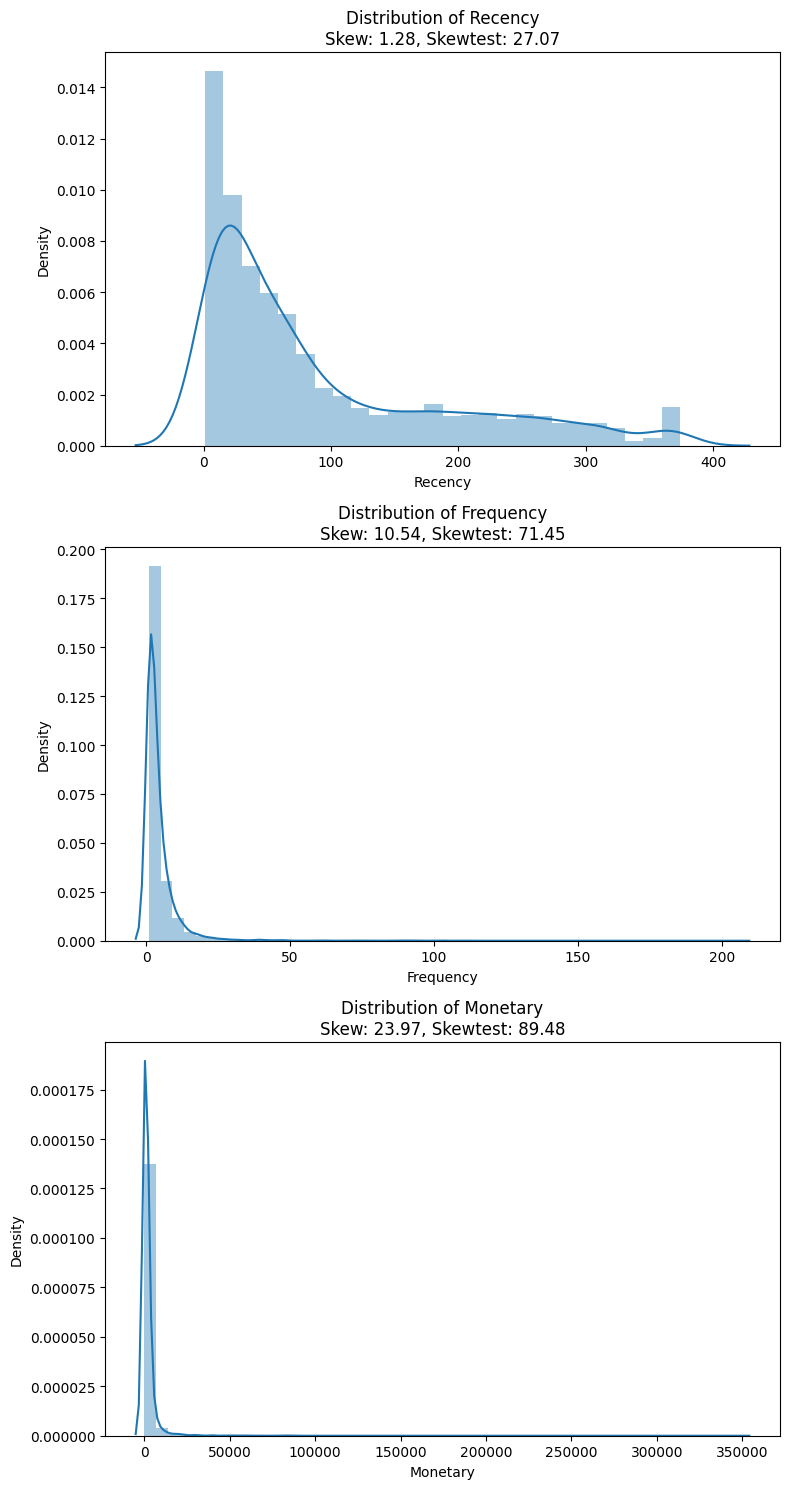

In [46]:
## Function to check skewness
def check_skew(df_skew, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(8, 15))

    for i, column in enumerate(columns):
        skew = stats.skew(df_skew[column])
        skewtest = stats.skewtest(df_skew[column])

        sns.distplot(df_skew[column], ax=axes[i])
        axes[i].set_title('Distribution of ' + column + '\nSkew: {:.2f}, Skewtest: {:.2f}'.format(skew, skewtest.statistic))
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

check_skew(rfm, ['Recency', 'Frequency', 'Monetary'])